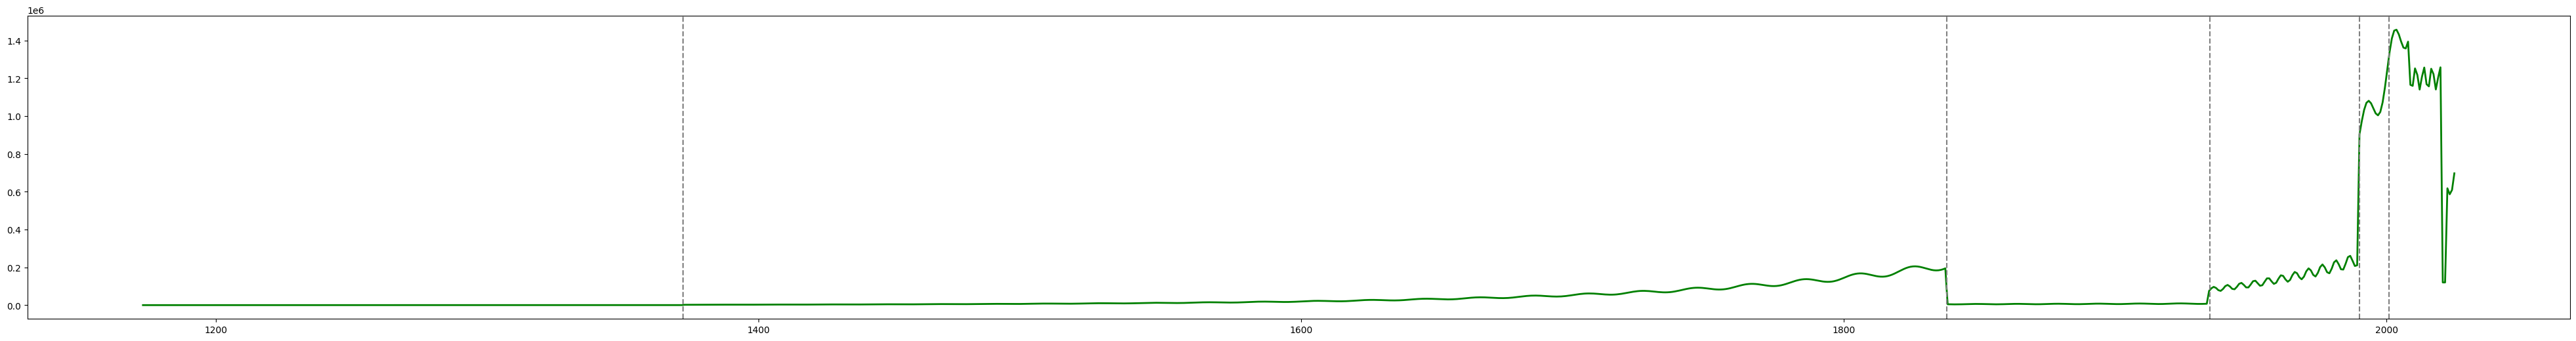

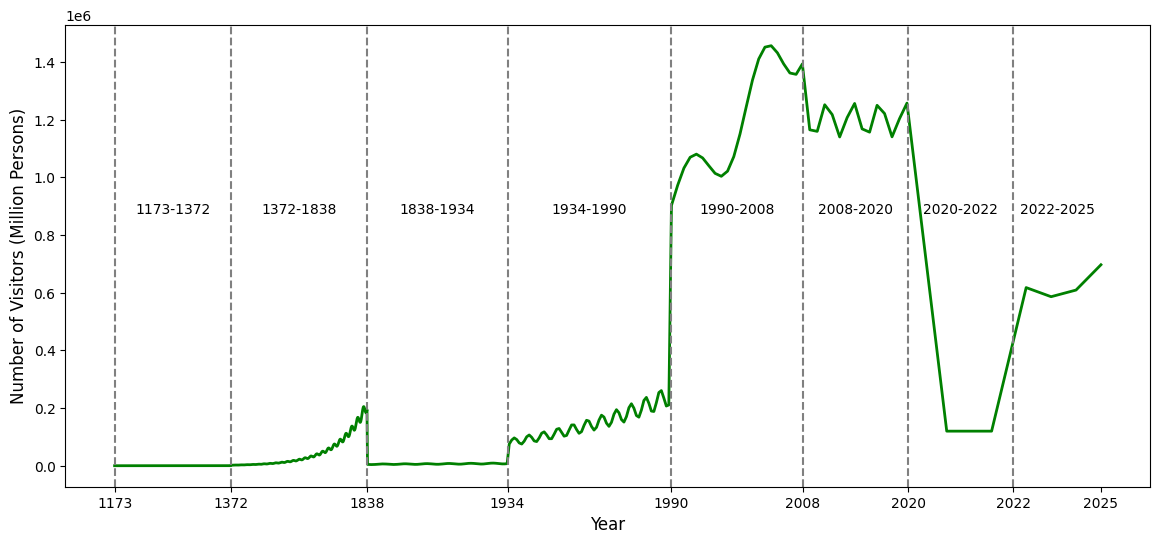

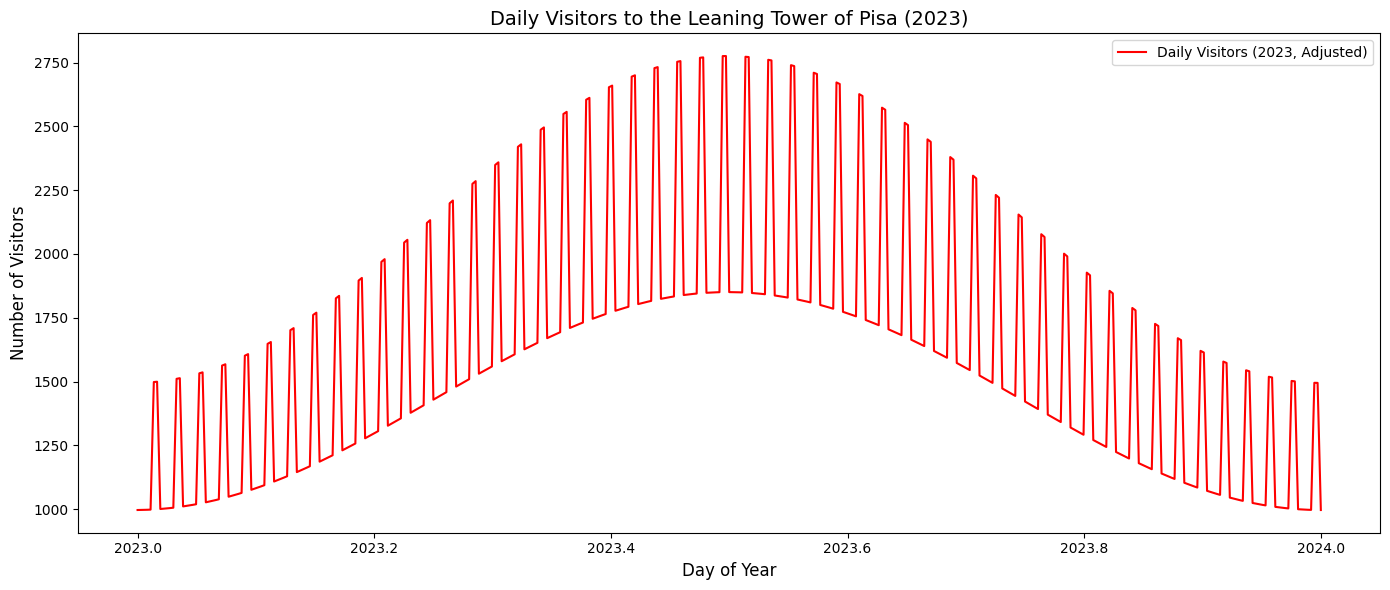

In [45]:
# 定义季节性波动函数
def seasonal_variation(day):
    A_season = 0.3  # 季节波动幅度
    phi_season = -np.pi / 2  # 峰值出现在夏季中间
    return 1 + A_season * np.sin(2 * np.pi * day / 365 + phi_season)

# 定义周末效应函数
def weekend_effect(day):
    # 每周的第几天，1=周一, ..., 7=周日
    weekday = day % 7
    if weekday in [6, 0]:  # 周六和周日
        return 1.5  # 周末增加50%流量
    else:
        return 1.0  # 工作日流量

# 嵌套年度游客人数和日度游客人数
def daily_visitors(year, day):
    # 获取年度游客人数
    annual_visitors_count = annual_visitors_updated(year)
    # 计算季节性波动和周末效应
    seasonal_factor = seasonal_variation(day)
    weekend_factor = weekend_effect(day)
    # 分配到每日游客人数
    return (annual_visitors_count / 365) * seasonal_factor * weekend_factor

# 定义年度游客人数模型
def annual_visitors_updated(t):
    def fluctuation(t, A, T):
        return 1 + A * np.sin(2 * np.pi * t / T)

    if t < 1372:
        N0 = 100
        r0 = 1
        A = 0.05
        T = 10
        return (N0 + r0 * (t - 1173)) * fluctuation(t, A, T)
    elif t < 1838:
        N1 = 2000
        r1 = 0.01
        A = 0.1
        T = 20
        return N1 * np.exp(r1 * (t - 1372)) * fluctuation(t, A, T)
    elif t < 1934:
        N2 = 5000
        r2 = 0.005
        A = 0.2
        T = 15
        return N2 * np.exp(r2 * (t - 1838)) * fluctuation(t, A, T)
    elif t < 1990:
        N3 = 100000
        r3 = 0.02
        A = 0.15
        T = 5
        return N3 * np.exp(r3 * (t - 1945)) * fluctuation(t, A, T)
    elif t < 2008:
        N4 = 900000
        r4 = 0.03
        A = 0.1
        T = 10
        return N4 * np.exp(r4 * (t - 1990)) * fluctuation(t, A, T)
    elif t < 2020:
        N5 = 1200000
        A = 0.05
        T = 3
        return N5 * fluctuation(t, A, T)
    elif t < 2022:
        N6 = 120000
        return N6
    else:
        N7 = 600000
        r5 = 0.05
        A = 0.1
        T = 5
        return N7 * np.exp(r5 * (t - 2022)) * fluctuation(t, A, T)

# 时间范围
years = np.linspace(1173, 2025, 1000)
days_in_year = range(1, 366)  # 一年的天数（非闰年）

# 计算年度游客人数
visitor_counts_updated = [annual_visitors_updated(t) for t in years]

# 计算2023年的每日游客人数
daily_visitors_updated = [daily_visitors(2023, day) for day in days_in_year]

# 调整每日游客人数使得总和与年度人数一致
daily_correction_factor = annual_visitors_updated(2023) / sum(daily_visitors_updated)
daily_visitors_updated = [v * daily_correction_factor for v in daily_visitors_updated]

# 绘制年度游客人数图（绿色）
plt.figure(figsize=(50, 6))
plt.plot(years, visitor_counts_updated, label='Annual Visitors (Updated)', color='green', linewidth=2)
plt.axvline(1372, color='gray', linestyle='--', label='1372: Completed')
plt.axvline(1838, color='gray', linestyle='--', label='1838: First Repair')
plt.axvline(1935, color='gray', linestyle='--', label='1935: WWII Impact')
plt.axvline(1990, color='gray', linestyle='--', label='1990: Closed for Repair')
plt.axvline(2001, color='gray', linestyle='--', label='2001: Reopened')

# 定义时间段
segments = [
    (1173, 1372),  # 建造时期
    (1372, 1838),  # 完工到首次修复
    (1838, 1934),  # 首次修复到二战
    (1934, 1990),  # 二战到关闭修复
    (1990, 2008),  # 修复到持续增长
    (2008, 2020),  # 高水平稳定
    (2020, 2022),  # 疫情影响
    (2022, 2025)   # 恢复增长
]

# 计算每段时间的长度
segment_lengths = [end - start for start, end in segments]

# 定义每个时间段的权重
segment_weights = [2,1,5,10,25,30,180,100]  # 权重可调节
normalized_weights = [w / sum(segment_weights) for w in segment_weights]  # 归一化权重

# 根据时间段长度和权重计算映射长度
segment_mapped_lengths = [length * weight for length, weight in zip(segment_lengths, normalized_weights)]
segment_positions_weighted = [0]  # 初始化横轴位置
for length in segment_mapped_lengths:
    segment_positions_weighted.append(segment_positions_weighted[-1] + length)


# 将年度数据重新映射到新的横轴比例
mapped_years_weighted = []
for t in years:
    for i, (start, end) in enumerate(segments):
        if start <= t < end:
            segment_start = segment_positions_weighted[i]
            segment_end = segment_positions_weighted[i + 1]
            mapped_years_weighted.append(
                segment_start + (t - start) / (end - start) * (segment_end - segment_start)
            )
            break

# 确保最后一个点映射到最后的区间
if len(mapped_years_weighted) < len(visitor_counts_updated):
    mapped_years_weighted.append(segment_positions_weighted[-1])

# 绘制调整后时间比例的年度游客人数图（带时间段权重）
plt.figure(figsize=(14, 6))
plt.plot(mapped_years_weighted, visitor_counts_updated, label='Annual Visitors (Weighted Time Density)', color='green', linewidth=2)

# 添加分段竖线和横向标签
for i, (start, end) in enumerate(segments):
    plt.axvline(segment_positions_weighted[i], color='gray', linestyle='--')
    plt.text(
        (segment_positions_weighted[i] + segment_positions_weighted[i + 1]) / 2,
        max(visitor_counts_updated) * 0.6,
        f"{start}-{end}",
        fontsize=10,
        ha='center'
    )

# 设置横轴刻度和单位
plt.xticks(segment_positions_weighted, [f"{start}" for start, _ in segments] + ["2025"], rotation=0)
plt.xlabel("Year", fontsize=12)  # 横轴单位为年
plt.ylabel("Number of Visitors (Million Persons)", fontsize=12)  # 纵轴单位为人数

# 去除网格线
plt.grid(False)

# 绘制日度游客人数图（红色）
plt.figure(figsize=(14, 6))
plt.plot(
    np.linspace(2023, 2024, len(daily_visitors_updated)),
    daily_visitors_updated,
    label='Daily Visitors (2023, Adjusted)',
    color='red',
    linewidth=1.5,
)

plt.title("Daily Visitors to the Leaning Tower of Pisa (2023)", fontsize=14)
plt.xlabel("Day of Year", fontsize=12)
plt.ylabel("Number of Visitors", fontsize=12)

# 去除网格线
plt.grid(False)

plt.legend()
plt.tight_layout()
plt.show()
